# 시계열 데이터 처리

In [1]:
import os
import datetime

import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

## 날씨 데이터 세트

> `막스 플랑크 생물 지구화학 연구소`에서 기록한 날씨정보로, 2003년부터 10분 간격으로 수집되었음.

In [2]:
DATA_SOURCE_URL = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

zip_file_path = tf.keras.utils.get_file(
    fname=os.path.basename(DATA_SOURCE_URL), 
    origin=DATA_SOURCE_URL, 
    extract=True
)

# 생략된 두번째 인자에는 분리된 확장자인 ".zip"가 저장됨
csv_file_path, _ = os.path.splitext(zip_file_path)

weather_df = pd.read_csv(csv_file_path)

### WEATHER_DF 정보

weather_df.info()
```python
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object  - 10분 단위 시간정보
 1   p (mbar)         420551 non-null  float64 - 대기압 (millibars)
 2   T (degC)         420551 non-null  float64 - 섭씨온도
 3   Tpot (K)         420551 non-null  float64 - 켈빈(절대)온도(0K = -273.15C)
 4   Tdew (degC)      420551 non-null  float64 - 습도
 5   rh (%)           420551 non-null  float64 - 상대습도
 6   VPmax (mbar)     420551 non-null  float64 - 포화증기압
 7   VPact (mbar)     420551 non-null  float64 - 증기압
 8   VPdef (mbar)     420551 non-null  float64 - 증기압부족(?)
 9   sh (g/kg)        420551 non-null  float64 - 비습도(?)
 10  H2OC (mmol/mol)  420551 non-null  float64 - 수증기 농도
 11  rho (g/m**3)     420551 non-null  float64 - 공기 밀도
 12  wv (m/s)         420551 non-null  float64 - 풍속
 13  max. wv (m/s)    420551 non-null  float64 - 최대풍속
 14  wd (deg)         420551 non-null  float64 - 풍향
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
```

weather_df.head()

In [3]:
weather_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 전처리 작업

#### 데이터 단위(10분 -> 1시간) 변경

In [4]:
# 시간별 예측을 위해 10분 단위 데이터를 1시간 단위 데이터로 변환

# weather_df[start:stop:step] -> [5::6]
# 첫번째 인덱스 번호인 5번부터, 끝까지, 6번째 데이터를 가져온다.
weather_df = weather_df[5::6]

In [5]:
# 당연하게도 둘다 동일한 결과를 도출한다.
## date_time1 = pd.to_datetime(weather_df["Date Time"])
## date_time2 = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

#### 시간정보 추출

In [6]:
# 문자열인 시간정보를 pandas의 시간데이터로 변경
# 변경하면서 시간정보를 추출함

date_time = pd.to_datetime(weather_df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")

#### 변경된 데이터 확인

* 인덱스값이 5부터 6개씩 스킵하면서 처리 됨
* `weather_df["Date Time"]`이 추출 됨
* `date_time`값 확인

In [7]:
weather_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

#### 원본 데이터 시각화

* 온도와 습도는 여름에 올라가고 겨울에 내려가는 패턴을 보여줌
* 풍속은 이상치 데이터에 의해 정상적인 표현이 안됨(추후 이상치 데이터 조정 후 다시 시각화함)

In [9]:
# 시각화 정보 설정
mpl.rcParams["figure.figsize"] = (12, 6)   # 출력 사이즈 12:6
mpl.rcParams["axes.grid"] = False          # 그리드 출력 않함

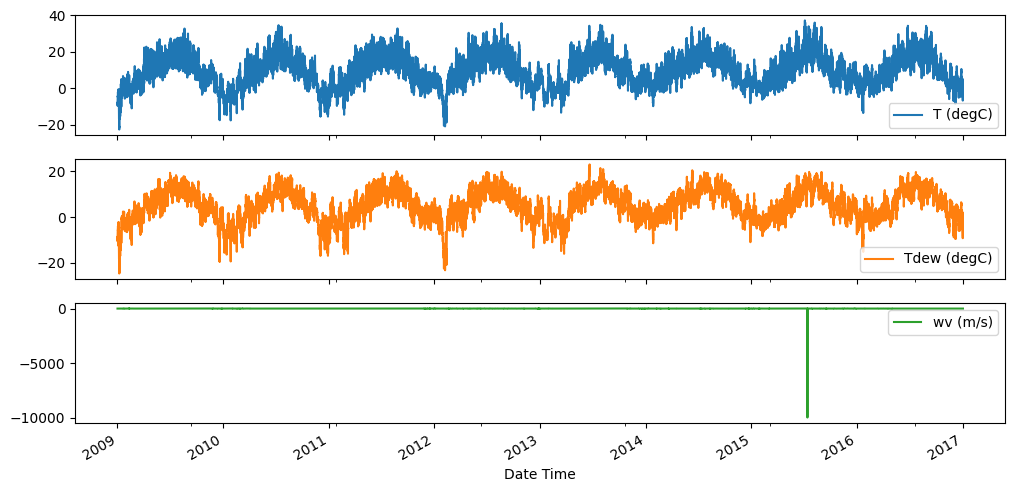

In [10]:
# 섭씨온도, 습도, 풍속
plot_columns = ["T (degC)", "Tdew (degC)", "wv (m/s)"]
plot_features = weather_df[plot_columns]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## 풍속 데이터는 잘못된 값(-9999.0)이 들어있어 정상적으로 출력되지 않음.

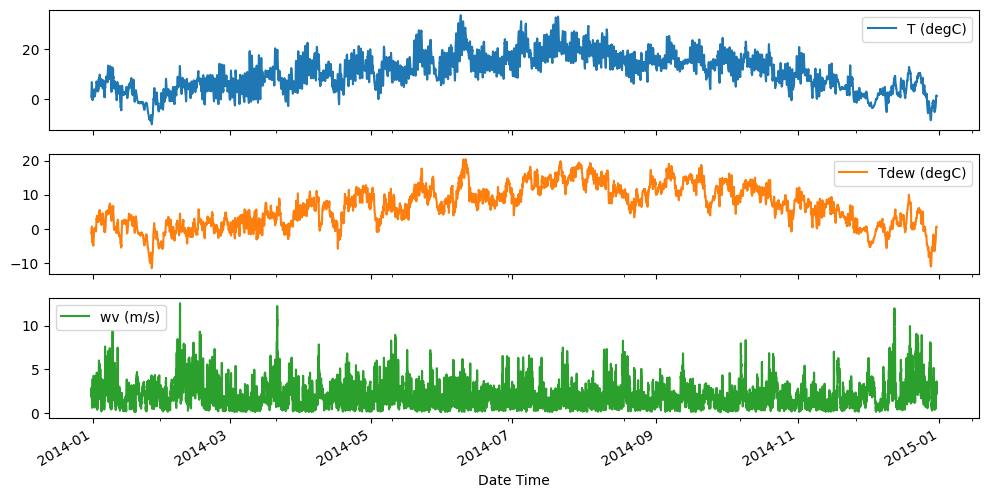

In [11]:
# 1년 데이터 시각화
## 정상적인 데이터 구간 시각화

BASE_YEAR = 2009
DISPLAY_YEAR = 2014
DAY_PER_YEAR = 365.2524
SAMPLE_START_INDEX = int(24 * DAY_PER_YEAR * (DISPLAY_YEAR - BASE_YEAR)) + 1
SAMPLE_END_INDEX = int(24 * DAY_PER_YEAR * (DISPLAY_YEAR - BASE_YEAR + 1))

plot_features = weather_df[plot_columns].iloc[SAMPLE_START_INDEX:SAMPLE_END_INDEX]
plot_features.index = date_time.iloc[SAMPLE_START_INDEX:SAMPLE_END_INDEX]
_ = plot_features.plot(subplots=True)

#### 통계 정보를 활용한 이상치 처리

##### 통계 정보 확인

In [12]:
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


##### 이상치 데이터 처리

* 풍속(wv (m/s))과 최대풍속(max. wv (m/s))는 값이 0 이하일 수 없기 때문에, 이 경우의 값은 0으로 처리

In [13]:
# deep=False로 추출된 시리즈가 변경되면 원본인 weather_df의 값도 함께 변경됨
wv_sr = weather_df["wv (m/s)"].copy(deep=False)              # 풍속
max_wv_sr = weather_df["max. wv (m/s)"].copy(deep=False)     # 최대풍속

bad_wv = wv_sr < 0.0
bad_max_wv = max_wv_sr < 0.0

# 추출된 
wv_sr[bad_wv] = 0.
max_wv_sr[bad_max_wv] = 0.

In [14]:
# 통계 확인(풍속/최대풍속 오탐값 수정 후 다시 통계 확인)
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


### 특성 엔지니어링

> 모델을 본격적으로 빌드하기 전에, 데이터에 대한 이해를 통해 적절한 형식의 데이터를 전달하는 과정

#### 바람 데이터

`풍속`은 도 단위로 바람의 방향을 나타내는데, 수치상으로 0도와 360도는 가장 큰 차이를 가지는 숫자지만, 가장 가까운 각도임을 정리해야 하며, 바람이 불지 않으면 풍속은 중요하지 않음을 표현해야 함

##### 원본 데이터의 "풍속"과 "풍향" 분포도

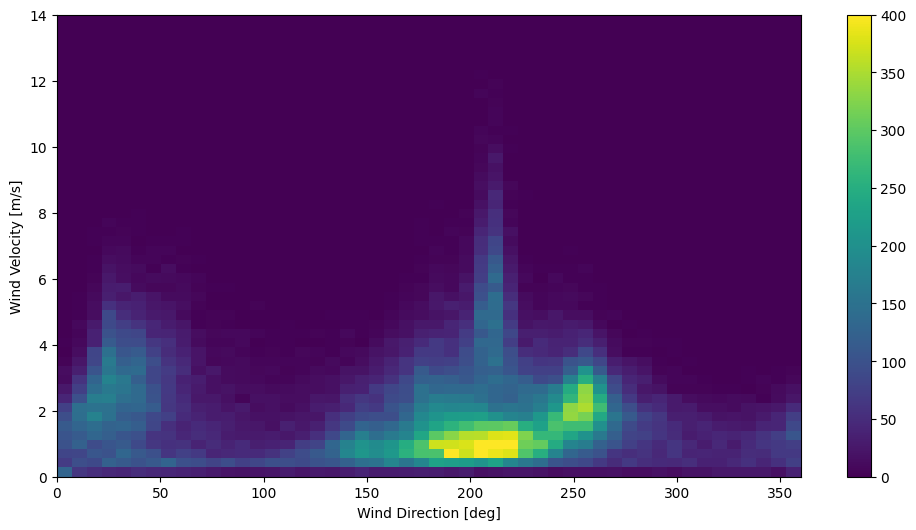

In [15]:
wd_sr, wv_sr = weather_df["wd (deg)"], weather_df["wv (m/s)"]

plt.hist2d(wd_sr, wv_sr, bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel("Wind Direction [deg]")
plt.ylabel("Wind Velocity [m/s]")
plt.show()

##### 풍향/풍속 벡터데이터 만들기

풍향과 풍속을 각 데이터로 사용하는 것 보다, 이 둘의 데이터를 벡터로 만들어 사용하면 모델이 더 이해하기 편해진다.

In [16]:
# 풍속, 최대풍속, 풍향을 추출함

temp_wv = weather_df.pop("wv (m/s)")
temp_max_wv = weather_df.pop("max. wv (m/s)")
temp_wd = weather_df.pop("wd (deg)")

In [17]:
# 풍향을 RADIANS으로 변경
temp_wd = temp_wd * np.pi / 180

# 풍속의 x, y값을 계산 후 데이터프레임에 추가
weather_df["Wx"] = temp_wv * np.cos(temp_wd)
weather_df["Wy"] = temp_wv * np.sin(temp_wd)
weather_df["max. Wx"] = temp_max_wv * np.cos(temp_wd)
weather_df["max. Wy"] = temp_max_wv * np.sin(temp_wd)

##### 바람 벡터 데이터 시각화

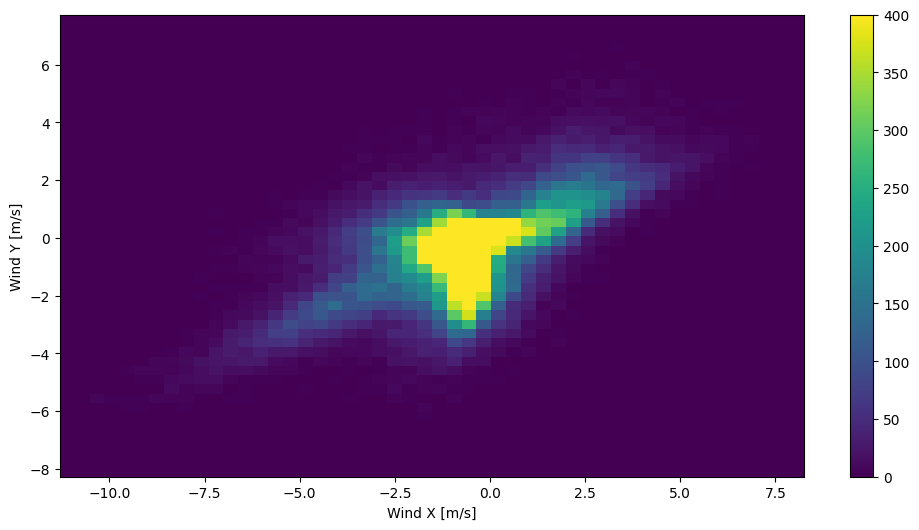

In [18]:
# 풍속 데이터
plt.hist2d(weather_df["Wx"], weather_df["Wy"], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel("Wind X [m/s]")
plt.ylabel("Wind Y [m/s]")
ax = plt.gca()
ax.axis("tight")
plt.show()

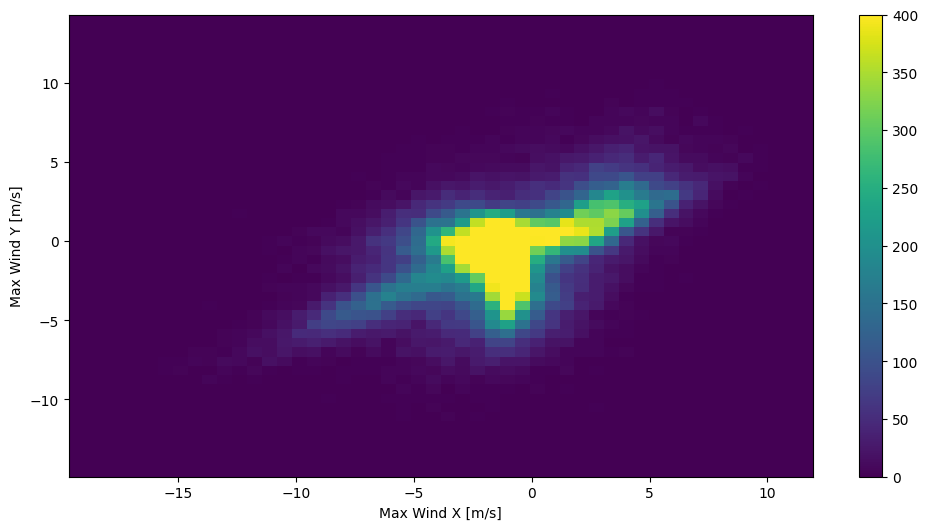

In [19]:
# 최대 풍속 데이터
plt.hist2d(weather_df["max. Wx"], weather_df["max. Wy"], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel("Max Wind X [m/s]")
plt.ylabel("Max Wind Y [m/s]")
ax = plt.gca()
ax.axis("tight")
plt.show()

#### 시간 데이터

시간 데이터도 문자열 형식의 데이터로 매우 유용하지만, 실제 초로 변환하면 더 유용하게 활용 할 수 있음

In [20]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

##### 초 -> 하루 및 연 단위 주기성 부여

In [21]:
DAY = 24 * 60 * 60
DAYS_PER_YEAR = 365.2425
YEAR = DAYS_PER_YEAR * DAY

In [22]:
weather_df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / DAY))
weather_df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / DAY))
weather_df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / YEAR))
weather_df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / YEAR))

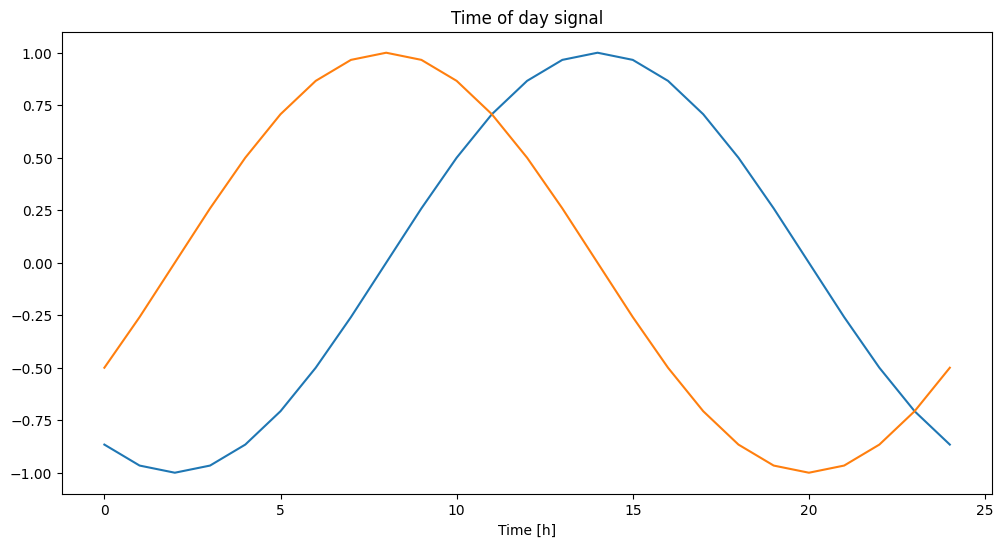

In [23]:
plt.plot(np.array(weather_df["Day sin"])[:25])
plt.plot(np.array(weather_df["Day cos"])[:25])
plt.xlabel("Time [h]")
plt.title("Time of day signal")
plt.show()

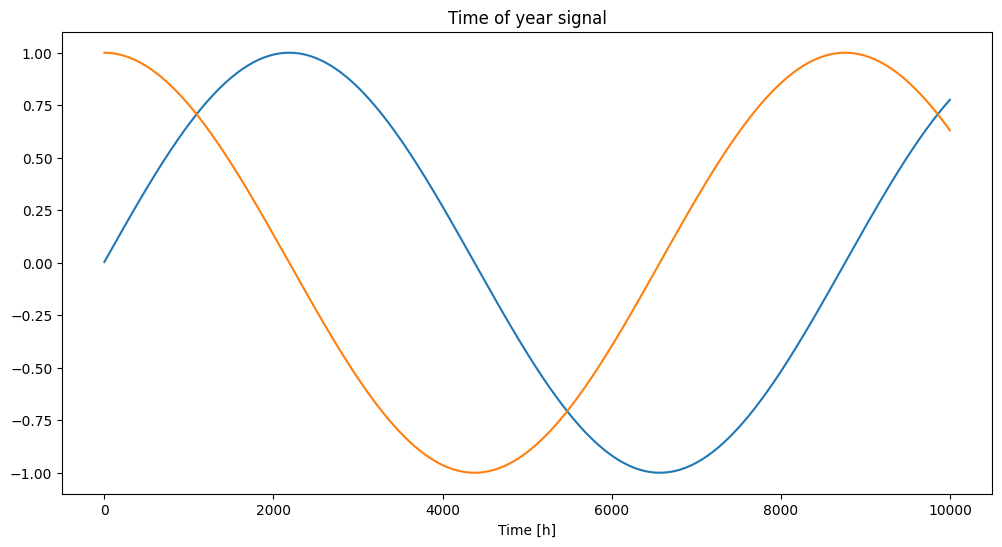

In [24]:
plt.plot(np.array(weather_df["Year sin"])[:10000])
plt.plot(np.array(weather_df["Year cos"])[:10000])
plt.xlabel("Time [h]")
plt.title("Time of year signal")
plt.show()

##### 빈도 특성 확인

In [25]:
fft = tf.signal.rfft(weather_df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))            # 일간 빈도수 표시 영역
n_samples_h = len(weather_df["T (degC)"])         # 전체 셈플 데이터 수
hours_per_year = 24 * DAYS_PER_YEAR               # 1년 시간수 = 24 * DAYS_PER_YEAR
years_per_dataset = n_samples_h / hours_per_year  # 데이터셋에 있는 년도 수 = 전체 셈플 데이터 수 / 1년 시간수
f_per_year = f_per_dataset / years_per_dataset    # 년간 빈도수 = 일간 빈도수 / 데이터셋에 있는 년도 수

2022-12-29 13:47:08.353256: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 13:47:10.192982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22836 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-12-29 13:47:10.196363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22353 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:af:00.0, compute capability: 7.5


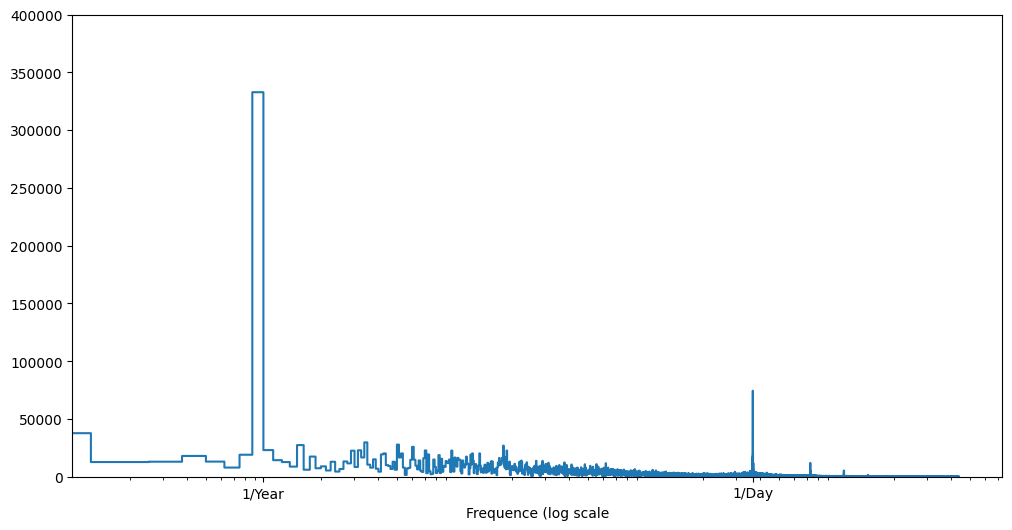

In [26]:
# 빈도수 시각화
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, DAYS_PER_YEAR], labels=["1/Year", "1/Day"])
_ = plt.xlabel("Frequence (log scale")
plt.show()

### 데이터 분할

훈련/검증/테스트 세트에 각각 70%/20%/10% 분할 사용하며, 시계열 데이터는 일반적으로 섞지 않는다.
* 데이터를 연속된 창으로 생성
* 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적임

In [27]:
column_indices = {name: i for i, name in enumerate(weather_df.columns)}

num_samples = weather_df.shape[0]
train_last_index = int(num_samples * 0.7)
val_last_index = int(num_samples * 0.9)

train_df = weather_df[:train_last_index]
val_df = weather_df[train_last_index:val_last_index]
test_df = weather_df[val_last_index:]

num_features = weather_df.shape[1]

### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 일정하게 정하는 것이 중요하며, 크기를 조정하는 일반적인 방법이 정규화 임
* 정규화 = (값 - 평균) / 표준편차
* 검증 및 테스트 데이터 값이 포함되지 않은, `훈련 데이터의 평균과 표준편차`를 이용해 처리함

In [28]:
mean_train = train_df.mean()
std_train = train_df.std()

In [29]:
train_df = (train_df - mean_train) / std_train
val_df = (val_df - mean_train) / std_train
test_df = (test_df - mean_train) / std_train

#### 정규화 데이터 시각화

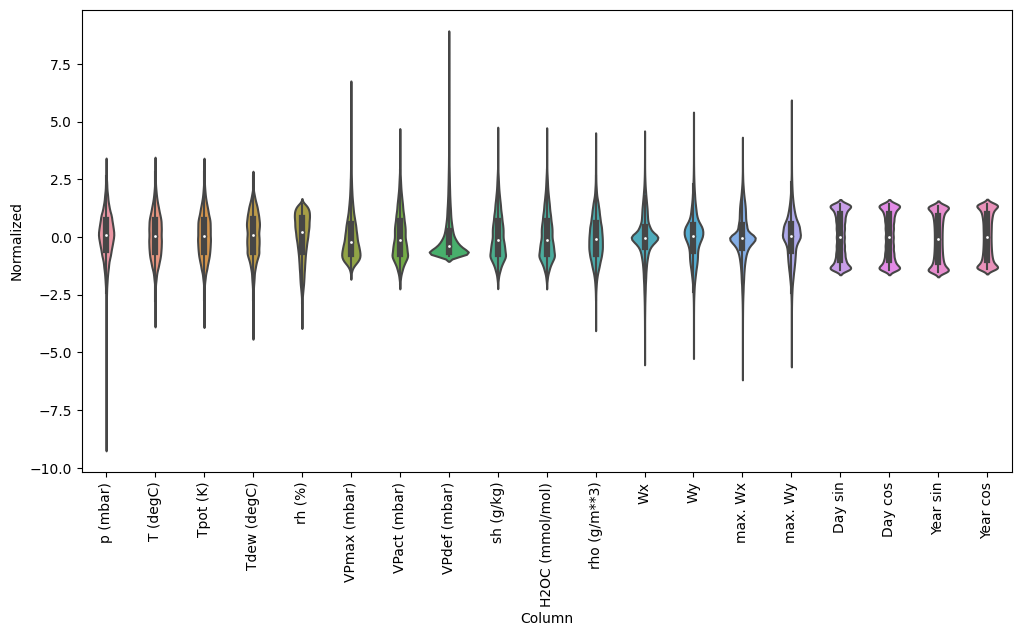

In [30]:
std_weather_df = (weather_df - mean_train) / std_train
std_weather_df = std_weather_df.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="Column", y="Normalized", data=std_weather_df)
_ = ax.set_xticklabels(weather_df.keys(), rotation=90)

## 데이터 창 작업

### 창 생성 클래스 정의

In [55]:
class WindowGenerator():
    
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None
    ):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = \
                {name: i for i, name in enumerate(label_columns)}
                
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"
        ])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(
        self, 
        model=None, 
        input_and_label=None,
        plot_col="T (degC)", 
        max_subplots=3
    ):
        inputs, labels = input_and_label
        
        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            
            plt.subplot(3, 1, n+1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices, 
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10
            )
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
                
            if label_col_index is None:
                continue
            
            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k", label="Labels", c="#2ca02c", s=64
            )
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X", edgecolors="k", label="Predictions", c="#ff7f0e", s=64
                )
                
            if n == 0:
                plt.legend()
                
            plt.xlabel("Time (h)")
            
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, "_example", None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [34]:
# 기본 WindowGenerator 테스트
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [45]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [41]:
# split_window 함수 테스트

example_window = tf.stack([
    np.array(train_df[:w2.total_window_size]),
    np.array(train_df[100:100+w2.total_window_size]),
    np.array(train_df[200:200+w2.total_window_size])
])
example_window

<tf.Tensor: shape=(3, 7, 19), dtype=float64, numpy=
array([[[ 9.45307599e-01, -1.98247323e+00, -2.04188844e+00,
         -1.91897277e+00,  1.11710152e+00, -1.30285119e+00,
         -1.47732321e+00, -7.90423621e-01, -1.48003637e+00,
         -1.48269721e+00,  2.21852381e+00,  1.93409239e-01,
          2.21161294e-01,  1.11140455e-01,  2.17927873e-01,
         -1.22480529e+00, -7.07148774e-01, -7.04125185e-02,
          1.42792166e+00],
        [ 9.59769847e-01, -2.07837211e+00, -2.13816632e+00,
         -2.06096373e+00,  1.04461734e+00, -1.33014257e+00,
         -1.53435391e+00, -7.86272298e-01, -1.53618981e+00,
         -1.53903452e+00,  2.32570755e+00,  1.72986774e-01,
          2.22100866e-01,  1.09458245e-01,  2.27798499e-01,
         -1.36607818e+00, -3.66055881e-01, -6.93893917e-02,
          1.42791767e+00],
        [ 9.86283967e-01, -2.07028426e+00, -2.13243549e+00,
         -2.04518696e+00,  1.06273839e+00, -1.32884298e+00,
         -1.52722507e+00, -7.88347960e-01, -1.52870268

In [42]:
example_inputs, example_labels = w2.split_window(example_window)

print(
    f"All shapes are: (batch, time, features)\n"
    f"Window shape: {example_window.shape}\n"
    f"Input shape: {example_inputs.shape}\n"
    f"Labels shape: {example_labels.shape}"
)

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Input shape: (3, 6, 19)
Labels shape: (3, 1, 1)


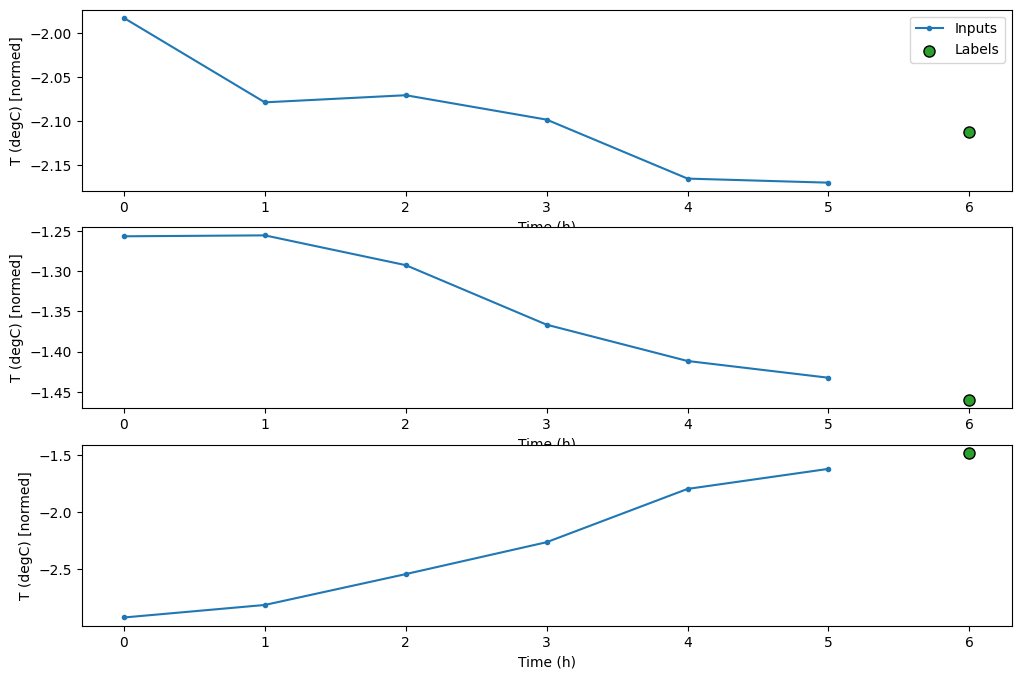

In [43]:
w2.plot(input_and_label=(example_inputs, example_labels))

In [46]:
# tf.dataset 테스트

w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [47]:
for example_inputs, example_labels in w2.train.take(1):
    print(
        f"Inputs shape(batch, time, features): {example_inputs.shape}\n"
        f"Labels shape(batch, time, features): {example_labels.shape}"
    )

Inputs shape(batch, time, features): (32, 6, 19)
Labels shape(batch, time, features): (32, 1, 1)


## 모델 학습

* 다양한 모델(선형, DNN, CNN 및 RNN) 활용
* 다양한 예측
  * 단일 출력 및 다중 출력 예측
  * 단일 타임스텝 및 다중 타임스템 예측

### 단일 스텝 모델

가장 간단한 예측 모델로, 현재 조건에 기초하여 미래로 1 타임스텝 진행된 단일 특성 값을 예측하는 모델.

#### 단일 스텝 쌍(input, label) 생성

In [56]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["T (degC)"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

#### 기준 설정

In [50]:
class Baseline(tf.keras.Model):
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [60]:
baseline = Baseline(label_index=column_indices["T (degC)"])
baseline.compile(
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)
val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [61]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=["T (degC)"]
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [62]:
wide_window.plot(baseline)

TypeError: cannot unpack non-iterable NoneType object